##  Demo timeline extraction
This is a demo to use chatGPT to extract the timeline of events from Woo-decision letters. To try the demo out, make sure there is 1 pdf file in the [demo/input](https://github.com/FemkeBakker/Timeline-Extraction-from-decision-letters-using-ChatGPT/tree/main/demo) folder. We have set up a default pdf-file, however you can insert any other PDF from the [code/data/preparation/IMIpdfs](https://github.com/FemkeBakker/Timeline-Extraction-from-decision-letters-using-ChatGPT/tree/main/code/data/preparation/IMIpdfs) folder. Do make sure that the demo/input only contains one pdf. 

As for the set-up of the API-key, please insert the key in [code/api.txt](https://github.com/FemkeBakker/Timeline-Extraction-from-decision-letters-using-ChatGPT/blob/main/code/api.txt). When using a pay-as-you-go please insert "paid" as argument of the "run_demo" function. When using a free api please insert "free" as argument of the "run_demo" function. You can create an API for ChatGPT on their [website](https://auth0.openai.com/u/login/identifier?state=hKFo2SBvMGZkdmRad2ZSVVkwRVZTeXQtdEZtZGEyWjVURDFJM6Fur3VuaXZlcnNhbC1sb2dpbqN0aWTZIEVRNWZBNnJnSlhaaFltZ0xxQ0FVa2xaQkx2Z3lFWHJ4o2NpZNkgRFJpdnNubTJNdTQyVDNLT3BxZHR3QjNOWXZpSFl6d0Q) where you can create an account.

Then, run the below cel and the output will be a sorted dataframe with the dates with an event, their class and event phrases. Depending on the length of document it will take about a 30 second to 3 minutes. This is calculated over the paid api, the free api will take longer to generate a timeline.

In [1]:
from code.scripts.filter import filter_and_extract
from code.scripts.date_correction import uncorrected_dates
from code.scripts.date_correction import compile
from code.scripts.decision import decision_class
from code.scripts.isodates import convert_date
# from code.scripts.make_timeline import json_timeline
from code.scripts.make_timeline import make_timeline
from code.scripts.json_timeline import display_svg_file
from code.scripts.json_timeline import json_timeline                    

from datetime import datetime

from dotenv import load_dotenv, find_dotenv

import shutil
import glob
import os
import pickle
import openai
import pandas as pd
import json


def run_demo(api_option):
    if api_option != 'free' and api_option != 'paid':
        print('Error: inserted invalid api_option. Please insert "paid" or "free" as API option.')
        return None

    # delete output for each run
    folder_path = 'demo/output'

    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)

    print('Checking if pdf is text or image based...')
    filter_and_extract("demo/input", "demo/output/results/txt", 0.1)


    # check quality of pdf & extract text
    folder_path = 'demo/output/results/txt'
    file_extension = '*.txt'

    txt_files = glob.glob(f"{folder_path}/{file_extension}")
    if len(txt_files) == 0:
        print("ERROR: pdf quality is too low -> pdf is image-based. Select different pdf as input.")
        return None
    else:
        print("Completed: Text extracted from pdf")

    # extract dates from text
    print(f"Selecting dates and sentences...")
    uncorrected_dates("demo/output/results/txt/", "demo/output/results", "")
    print("Completed: dates extracted from text.")

    
    # correct dates
    with open('demo/output/results/uncorrected_dates_.pkl', 'rb') as fp:
        test_uncorrected = pickle.load(fp)

    print(f"Correcting dates...")
    # get second results of test set
    test_corrected = compile(test_uncorrected)
    print(f"Completed: dates corrected.")


    # extracting the decision date
    print(f"Extracting the decision date...")
    test_decision = decision_class(test_corrected)
    test_decision['id'] = range(len(test_decision))

    timeline = test_decision.copy()
    timeline.loc[timeline['decisiondate'] == True, 'decisiondate'] = "besluit datum"
    timeline = timeline.rename(columns={"decisiondate":"class"})
    timeline = timeline.loc[timeline['class'] != False]
    print(f"Completed: decision date extracted")

    # set up chatGPT
    print(f"Setting up API of ChatGPT...")
    _ = load_dotenv(find_dotenv()) # read local .env file

    # store api in text file, extract here
    with open("code/api.txt", 'r') as f:
        api = f.read()

    # openai.api_key  = os.getenv(api)
    openai.api_key = api
    print(f"Completed: API of ChatGPT is set")

    print(f"Loading training data...")
    gt_train = pd.read_csv("code/data/GT/GTtrain/date_event_combinations.csv")
    # gt_train['class'] = gt_train['label'].apply(lambda x: x.split(': ')[1] if ': ' in x else x)
    print(f"Completed: training data loaded")

    from code.scripts.chatgpt_extraction import run
    print(f"Classifying dates into True/False & extracting event phrase...")
    run(test_decision.loc[test_decision['decisiondate'] == False], 1, "demo/output/results/", gt_train, api_option)
    print(f"Completed: Dates classified into with and without event & event phrases extracted")

    # select dates with an event
    predictions = pd.read_csv("demo/output/results/predictions.csv")
    predictions = predictions.loc[predictions['prediction_class'] == True]  

    print(f"Classifying dates with an event into an event class...")
    input_chatgpt = predictions.drop(columns=['prediction_class', 'batch', 'batch_runtime', 'run_id', 'prompt'])

    from code.scripts.chatgpt_classification import run
    # gt = pd.read_csv("data/GTtrain1-6/date_event_combinations.csv")
    try_run = run(input_chatgpt, 1, "demo/output/results/chatgpt", gt_train, api_option)
    print(f"Completed: dates with an event classified into event classes")

    # dropping unnessecarry columns
    prediction_class = pd.read_csv("demo/output/results/chatgptpredictions.csv")
    prediction_class_clean = prediction_class.drop(columns=['decisiondate', 'batch', 'batch_runtime', 'run_id', 'prompt'])
    prediction_class_clean = prediction_class_clean.rename(columns={'prediction':'class'})
    timeline = pd.concat([prediction_class_clean, timeline])

    # convert dates in ISO_date
    print("Converting dates into ISO date format & sort dates...")
    timeline = convert_date(timeline).sort_values(by=['ISO_date'])
    show_timeline = timeline.drop(columns=['label', 'corrected', 'start_in_text', 'end_in_text', 'start_in_sent', 'end_in_sent', 'id', 'complete_date', 'doc_id'])
    show_timeline = show_timeline[['date', 'class', 'prediction_event', 'sentence', 'ISO_date']]
    print("Completed: dates converted to ISO date and sorted")

    # show complete sentences
    pd.set_option('display.max_colwidth', None)

    # create json file
    json_dict = json_timeline(show_timeline, "demo/output/results/timeline.json")

    # convert json file into timeline
    make_timeline("demo/output/results/timeline.json", 'demo/output/timeline.svg')

    # show timeline
    display_svg_file('demo/output/timeline.svg')
    display(show_timeline)

    
    return show_timeline
 

Checking if pdf is text or image based...
('text', 'Besluit+op+Wob-verzoek+over+informatie+over+diertellingen+Bredesteeg+37+te+Echteld.pdf')
Completed: Text extracted from pdf
Selecting dates and sentences...
at document 1 out of 1
Completed: dates extracted from text.
Correcting dates...
Completed: dates corrected.
Extracting the decision date...
Completed: decision date extracted
Setting up API of ChatGPT...
Completed: API of ChatGPT is set
Loading training data...
Completed: training data loaded
Classifying dates into True/False & extracting event phrase...
Completed: Dates classified into with and without event & event phrases extracted
Classifying dates with an event into an event class...
Completed: dates with an event classified into event classes
Converting dates into ISO date format & sort dates...
Completed: dates converted to ISO date and sorted


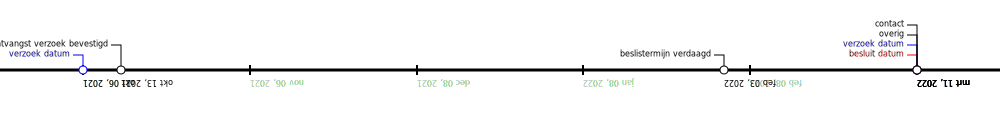

,date,class,prediction_event,sentence,ISO_date
0,6 oktober 2021,verzoek datum,u heeft met een beroep op de Wet openbaarheid van bestuur verzocht om informatie over diertellingen van het bedrijf Bredesteeg 37 te Echteld,", In uw e-mail van 6 oktober 2021 heeft u met een beroep op de Wet openbaarheid van bestuur (hierna: Wob) verzocht om informatie over diertellingen van het bedrijf Bredesteeg 37 te Echteld.",2021-10-06
1,13 oktober 2021,ontvangst verzoek bevestigd,De ontvangst van uw verzoek is schriftelijk bevestigd,Procedure De ontvangst van uw verzoek is schriftelijk bevestigd bij brief van 13 oktober 2021 met kenmerk WOB/2021/252.,2021-10-13
2,3 februari 2022,beslistermijn verdaagd,de beslistermijn met twee weken is verlengd vanwege het vragen van zienswijzen aan derden,In de brief van 3 februari 2022 is aan u medegedeeld dat de beslistermijn met twee weken is verlengd vanwege het vragen van zienswijzen aan derden.,2022-02-03
3,11 maart 2022,contact,None,Gebruikt u dit nummer als u contact met ons 11 maart 2022 heeft.,2022-03-11
4,11 maart 2022,overig,None,11 maart 2022 2.,2022-03-11
5,11 maart 2022,verzoek datum,Rijksdienst voor Ondernemend Nederland Vergunningen en Handhaving Inventarislijst opgevraagde gegevens,Rijksdienst voor Ondernemend Nederland Vergunningen en Handhaving Inventarislijst opgevraagde gegevens Datum 11 maart 2022 Bijlage nummer 2 Onze referentie Horend bij Verzoek openbaarmaking gegevens WOB/2021/252 Datum Onze referentie WOB/2021/252 Contactpersoon Inventarislijst opgevraagde gegevens Nummer Document WOB Art.,2022-03-11
32,11 maart 2022,besluit datum,NaN,Datum 11 maart 2022,2022-03-11


In [2]:
timeline = run_demo("paid")